###### import

In [1]:
import datetime

import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import shap

###### load data

In [2]:
dataset_file_path = '/content/drive/MyDrive/ocp-hackathon/data.h5'

dcs = pd.read_hdf(dataset_file_path, key='DCS')
lab = pd.read_hdf(dataset_file_path, key='LAB')
pulp = pd.read_hdf(dataset_file_path, key='PULP')
target = pd.read_hdf(dataset_file_path, key='TARGETS')

In [3]:
target = target.xs('X', level='FILTER') # focus on filter X only

In [4]:
dcs.index = pd.to_datetime(dcs.index)
lab.index = pd.to_datetime(lab.index)
pulp.index = pd.to_datetime(pulp.index)
target.index = pd.to_datetime(target.index)

###### utils

In [5]:
# calc first/third q then remove outliers
def set_anomalies_to_nan(df, multiplier=1.5) -> None:
    columns = df.columns
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - multiplier * IQR
        upper_bound = Q3 + multiplier * IQR

        df[col] = df[col].where(
            (df[col] >= lower_bound) & (df[col] <= upper_bound),
            np.nan
        )

    return df

In [6]:

# util function to show percentage of nan values of each column
nan_percentage = lambda df: (df.isnull().sum() / df.shape[0]) * 100

###### drop nan values of target

In [7]:
target.columns.tolist()

['TITRE', 'RENDEMENT', '%P2O5 Int', '%P2O5 Syn', '%P2O5 SE', '%CaO']

In [8]:
selected_target_column = 'TITRE'

In [9]:
target = target[[selected_target_column]]

In [10]:
target = set_anomalies_to_nan(target)

In [11]:
target = target.dropna()

###### remove columns related by Y filter from DCS and LAB dataframes

In [12]:
# filter lab
lab_columns_y_to_remove = ['PRODUCED_ACID_DS_Y', 'MODERATE_ACID_DS_Y', 'WEAK_ACID_DS_Y']

# filter dcs
dcs_columns_y_to_remove = [
  'Débit acide recyclé (FY)',
  'Débit de bouillie (FY)',
  'Vitesse du filtre (FY)',
  'Débit eau de lavage filtre (FY)',
  'Vide des filtres (FY)',
  'Température de lavage toile (FY)',
  'Pression de lavage toile (FY)',
  'Niveau de bac de lavage (FY)'
]

In [13]:
lab = lab.drop(columns=lab_columns_y_to_remove)
dcs = dcs.drop(columns=dcs_columns_y_to_remove)

###### get start/end date of intersection between all dataframes

In [14]:
start_date = max(dcs.index.min(), lab.index.min(), pulp.index.min(), target.index.min())
end_date = min(dcs.index.max(), lab.index.max(), pulp.index.max(), target.index.max())

In [15]:
# Normalizes a start/end datetime pair to the exchange's "trading day" convention:
# A trading day officially starts at 07:00 and ends at 06:59:59.999 of the next calendar day.
# • For start_date: moves any timestamp before 07:00 to 07:00 of the same calendar day,
#   and any timestamp from 07:00 onwards to 07:00 of the next calendar day.
# • For end_date: moves any timestamp before 07:00 to 07:00 of the previous calendar day,
#   and any timestamp from 07:00 onwards to 07:00 of the same calendar day.
# This effectively aligns both boundaries to the 07:00 "cut-off" so that a continuous
# period (e.g., one full trading day) is represented by the interval [07:00, 07:00).

def get_normalized_dates(start_date, end_date) -> tuple:
    dt_start = pd.to_datetime(start_date)
    base = dt_start.normalize()
    if dt_start.time() < datetime.time(7, 0):
        start_date_normalized = base + pd.Timedelta(hours=7)
    else:
        start_date_normalized = base + pd.Timedelta(days=1, hours=7)

    dt_end = pd.to_datetime(end_date)
    base = dt_end.normalize()
    if dt_end.time() < datetime.time(7, 0):
        end_date_normalized = base + pd.Timedelta(days=-1, hours=7)
    else:
        end_date_normalized = base + pd.Timedelta(hours=7)
    return start_date_normalized, end_date_normalized

In [16]:
start_date, end_date = get_normalized_dates(start_date, end_date)

In [17]:
dcs = dcs.loc[start_date:end_date]
lab = lab.loc[start_date:end_date]
pulp = pulp.loc[start_date:end_date]
target = target.loc[start_date:end_date]

###### remove dcs/pulp/lab anomalies with replace them by nan

In [18]:
dcs = set_anomalies_to_nan(dcs)
lab = set_anomalies_to_nan(lab)
pulp = set_anomalies_to_nan(pulp)

###### fill nan by interpolate.linear

In [19]:
def fill_nan_by_interpolate(df) -> pd.DataFrame:
  for col in df.columns:
    df[col] = df[col].interpolate(method='linear', limit_direction='both')
  return df

In [20]:
# dcs['Débit des boues 29Y vers a CA'].fillna(0).describe()

In [21]:
# this column is 46% nan, and other values are outliers
# that why we decided to remove it
dcs.drop(columns=['Débit des boues 29Y vers a CA'], inplace=True)

In [22]:
dcs = fill_nan_by_interpolate(dcs)
lab = fill_nan_by_interpolate(lab)
pulp = fill_nan_by_interpolate(pulp)

###### aggregate dcs from min to hour

In [23]:
# collapse all minutes into one hour by calculate mean
dcs = dcs.resample('h', label='right').mean()

###### shift dcs, lab data to mid-night instead 07:00 am, use it later for merge

In [24]:
dcs.index = dcs.index - pd.Timedelta(hours=7)
lab.index = lab.index - pd.Timedelta(hours=7)

###### merge dcs, pulp and lab

In [25]:
# merge dcs with lab
data = pd.merge(dcs, lab, left_index=True, right_index=True, how='inner')

# add date_day column to merge with pulp and target
data['date_day'] = pd.to_datetime(data.index.date)

# merge data with pulp
data = pd.merge(data, pulp, left_on='date_day', right_index=True, how='inner')

# drop date_day column
data = data.drop(columns=['date_day'])

###### normalise/standardize data

In [26]:
# create dataframe contain each column and its std, mean
stats = data.describe().loc[['mean', 'std']]

In [27]:
# normalise data based on stats
data = (data - stats.loc['mean']) / stats.loc['std']

###### merge result data to target

In [28]:
# before: recomended to normalise for model better learning (prevent vanishing gradient)
if selected_target_column == 'TITRE':
  target[selected_target_column] = (target[selected_target_column] * 10) - 250 # TITRE

elif selected_target_column == 'RENDEMENT':
  target[selected_target_column] = (target[selected_target_column] * 10) - 940 # RENDEMENT

else:
  target[selected_target_column] = target[selected_target_column] * 10 # OTHERS

In [29]:
# target.describe()

In [30]:
# add date_day column to merge with pulp and target
data['date_day'] = pd.to_datetime(data.index.date)

# merge data with target
data = pd.merge(data, target, left_on='date_day', right_index=True, how='inner')

# drop date_day column
data = data.drop(columns=['date_day'])

###### create sliding window of 24 day with 4 hours step

In [31]:
data = data.asfreq('h')
data = data.bfill()

In [32]:
WINDOW_LEN = 24
STEP_SIZE = 4

X_input = data.drop(columns=selected_target_column).values
y_input = data[selected_target_column].values

x_windows = sliding_window_view(X_input, window_shape=WINDOW_LEN, axis=0)

x_windows = np.moveaxis(x_windows, -1, -2)

y_windows = sliding_window_view(y_input, window_shape=WINDOW_LEN, axis=0)

data_x = x_windows[::STEP_SIZE]
y_stepped = y_windows[::STEP_SIZE]

data_y = y_stepped[:, -1]
data_y = data_y.reshape(-1, 1)

###### model

In [33]:
# class Model(nn.Module):
#     def __init__(self, input_size: int, output_size: int):
#         super(Model, self).__init__()
#         lstm_hidden_size = 512
#         lstm_num_layers = 27
#         self.lstm = nn.LSTM(
#             input_size=input_size,
#             hidden_size=lstm_hidden_size,
#             num_layers=5,
#             batch_first=True
#         )
#         self.fc = nn.Linear(lstm_hidden_size, output_size)

#     def forward(self, x):
#         x, _ = self.lstm(x)
#         x = self.fc(x[:, -1, :])
#         return x

In [34]:
class Model(nn.Module):
    def __init__(self, input_size: int, output_size: int):
        super(Model, self).__init__()

        self.conv_block = nn.Sequential(
            # Conv1: (batch, input_size, L) -> (batch, 64, L)
            nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),

            # Conv2: -> (batch, 128, L/2)
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),

            # Conv3: -> (batch, 256, L/2)
            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),

            # Conv4: -> (batch, 512, L/4)
            nn.Conv1d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
        )

        self.adaptive_pool = nn.AdaptiveAvgPool1d(1)

        self.fc = nn.Sequential(
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, output_size)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.transpose(1, 2)

        x = self.conv_block(x)

        x = self.adaptive_pool(x)

        x = x.flatten(start_dim=1)

        x = self.fc(x)

        return x

###### train function

In [35]:
# train function
def train(
    model: nn.Module,
    loader: DataLoader,
    epochs: int,
    val_loader: DataLoader | None = None,
) -> dict:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Loss & optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # History
    history = {"train_loss": [], "val_loss": [] if val_loader else None}

    print(f"Training on {device} for {epochs} epochs...\n")

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0.0
        for x, y in loader:
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            y_pred = model(x)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(loader)
        history["train_loss"].append(avg_train_loss)

        # Validation (optional)
        val_loss = None
        if val_loader:
            model.eval()
            val_running_loss = 0.0
            with torch.no_grad():
                for x_val, y_val in val_loader:
                    x_val, y_val = x_val.to(device), y_val.to(device)
                    y_val_pred = model(x_val)
                    val_running_loss += criterion(y_val_pred, y_val).item()
            val_loss = val_running_loss / len(val_loader)
            history["val_loss"].append(val_loss)

        # Print
        if val_loader:
            print(f"Epoch {epoch+1:3d}/{epochs} | Train Loss: {avg_train_loss:.7f} | Val Loss: {val_loss:.6f}")
        else:
            print(f"Epoch {epoch+1:3d}/{epochs} | Train Loss: {avg_train_loss:.7f}")

    print("\nTraining finished!")
    return history

###### dataloader

In [36]:
class CustomDataset(Dataset):
    def __init__(self, x: np.ndarray, y: np.ndarray):
        super(CustomDataset, self).__init__()
        self.x = torch.from_numpy(x).float()
        self.y = torch.from_numpy(y).float()

    def __len__(self) -> int:
        return len(self.x)

    def __getitem__(self, idx) -> tuple[torch.Tensor]:
        return self.x[idx], self.y[idx]

In [37]:
def get_train_test_dataloader(x: torch.Tensor, y: torch.Tensor,ratio: float, batch_size: int) -> tuple[DataLoader, DataLoader]:
    assert ratio > 0 and ratio < 1, "ratio must be between 0 and 1"

    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=ratio, random_state=42)

    # train_size = int(ratio * len(all_x))
    # test_size = len(all_x) - train_size

    train_dataset = CustomDataset(X_train, y_train)
    test_dataset = CustomDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

###### start train

In [38]:
# create model
model = Model(input_size=data_x.shape[2], output_size=data_y.shape[1])

In [39]:
# get train, test loaders
train_loader, test_loader = get_train_test_dataloader(data_x, data_y, 0.8, 64)

In [40]:
# start traning
history = train(model, train_loader, 150, test_loader)

Training on cuda for 150 epochs...

Epoch   1/150 | Train Loss: 14.2899569 | Val Loss: 9.887618
Epoch   2/150 | Train Loss: 9.0882018 | Val Loss: 7.930092
Epoch   3/150 | Train Loss: 7.6880019 | Val Loss: 7.557617
Epoch   4/150 | Train Loss: 6.5609328 | Val Loss: 7.305875
Epoch   5/150 | Train Loss: 6.0747118 | Val Loss: 6.649138
Epoch   6/150 | Train Loss: 5.5854047 | Val Loss: 6.314600
Epoch   7/150 | Train Loss: 4.8705263 | Val Loss: 7.205708
Epoch   8/150 | Train Loss: 4.3248834 | Val Loss: 6.797551
Epoch   9/150 | Train Loss: 4.2179657 | Val Loss: 6.394890
Epoch  10/150 | Train Loss: 3.9418884 | Val Loss: 6.330146
Epoch  11/150 | Train Loss: 3.7771548 | Val Loss: 6.063660
Epoch  12/150 | Train Loss: 3.5911282 | Val Loss: 7.139630
Epoch  13/150 | Train Loss: 3.2543815 | Val Loss: 6.503009
Epoch  14/150 | Train Loss: 3.0971430 | Val Loss: 6.505842
Epoch  15/150 | Train Loss: 3.0308171 | Val Loss: 7.703432
Epoch  16/150 | Train Loss: 2.9659741 | Val Loss: 7.474674
Epoch  17/150 | Tra

###### model metrics

In [41]:
def test(model: nn.Module, loader: DataLoader) -> tuple[torch.Tensor, torch.Tensor]:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    predictions = []
    targets = []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y_pred = model(x)
            predictions.append(y_pred.cpu())
            targets.append(y)
    predictions = torch.cat(predictions, dim=0)
    targets = torch.cat(targets, dim=0)
    return predictions, targets

In [42]:
def r2_score(y_pred, y_true):
    y_pred = y_pred.flatten()
    y_true = y_true.flatten()

    ss_tot = torch.sum((y_true - torch.mean(y_true)) ** 2)

    ss_res = torch.sum((y_true - y_pred) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2.item()

In [43]:
def rmse(y_pred, y_true):
    y_pred = y_pred.flatten()
    y_true = y_true.flatten()

    mse = torch.mean((y_true - y_pred) ** 2)
    rmse_val = torch.sqrt(mse)

    return rmse_val.item()

In [44]:
def mse(y_pred, y_true):
    y_pred = y_pred.flatten()
    y_true = y_true.flatten()
    return torch.mean((y_true - y_pred) ** 2).item()

In [45]:
pred_y, true_y = test(model, test_loader)

In [46]:
rmse(pred_y, true_y)

2.3926854133605957

In [47]:
r2_score(pred_y, true_y)

0.7856279611587524

In [48]:
mse(pred_y, true_y)

5.724943161010742

###### features importances with DeepSHAP

In [49]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
background_data = torch.from_numpy(data_x[10:]).float().to(device)
to_explain = torch.from_numpy(data_x[:10]).float().to(device)

/tmp/ipython-input-3372737532.py:2: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:206.)
  background_data = torch.from_numpy(data_x[10:]).float().to(device)


In [50]:
explainer = shap.DeepExplainer(model, background_data)
shap_values = explainer.shap_values(to_explain)

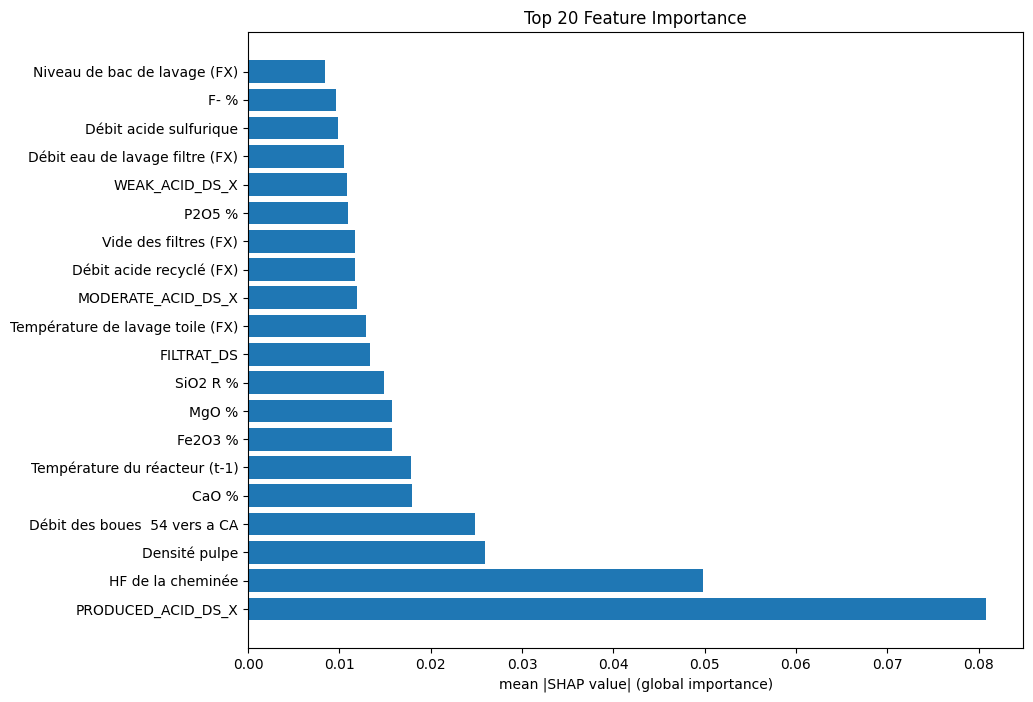

In [51]:
shap_importance = np.abs(shap_values).mean(axis=(0, 1, 3))  # shape (42,)

feature_names = [col for col in data.columns]  # or your real names

plt.figure(figsize=(10, 8))
indices = np.argsort(shap_importance)[::-1]
plt.barh(range(20), shap_importance[indices[:20]][::-1])
plt.yticks(range(20), np.array(feature_names)[indices[:20]][::-1])
plt.xlabel("mean |SHAP value| (global importance)")
plt.title("Top 20 Feature Importance")
plt.gca().invert_yaxis()
plt.show()